In [ ]:
#!pip install torch torchaudio librosa matplotlib scikit-learn
#!pip install torchsummary
#!pip install --upgrade numpy torchsummary
#!pip install torchviz



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#!pip install "numpy<2"
#!conda install numpy<2

The system cannot find the file specified.


In [2]:
import torch
import numpy as np

t = torch.tensor([1.0, 2.0, 3.0])
print(t.numpy())  # Should print: [1. 2. 3.]

[1. 2. 3.]


In [ ]:
import os
import torch
import torchaudio
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchsummary import summary

In [2]:
LIBRISPEECH_DIR = "Dataset/train-clean-100/LibriSpeech/train-clean-100/"  

# List of speaker folders
speaker_dirs = sorted(os.listdir(LIBRISPEECH_DIR))[:10]
speaker_to_idx = {spk: idx for idx, spk in enumerate(speaker_dirs)}
print("Speaker Index Map:", speaker_to_idx)

Speaker Index Map: {'103': 0, '1034': 1, '1040': 2, '1069': 3, '1081': 4, '1088': 5, '1098': 6, '1116': 7, '118': 8, '1183': 9}


In [4]:
class LibriSpeechSpeakerDataset(Dataset):
    def __init__(self, root_dir, speaker_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.speaker_to_idx = speaker_to_idx
        self.target_length = 800  # Fixed number of time steps (adjustable)

        for spk in speaker_to_idx.keys():
            spk_dir = os.path.join(root_dir, spk)
            for chapter in os.listdir(spk_dir):
                chapter_dir = os.path.join(spk_dir, chapter)
                for file in os.listdir(chapter_dir):
                    if file.endswith(".flac"):
                        self.samples.append({
                            "path": os.path.join(chapter_dir, file),
                            "label": speaker_to_idx[spk]
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        waveform, sample_rate = torchaudio.load(sample["path"])

        # Resample to 16kHz if needed
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        # Convert to Mel spectrogram (shape: [1, 64, time])
        mel_spec = MelSpectrogram(sample_rate=16000, n_mels=64)(waveform)
        mel_db = AmplitudeToDB()(mel_spec).squeeze(0)  # shape: [64, time]

        # ✅ Trim or pad to fixed width (target_length = 800)
        if mel_db.shape[1] > self.target_length:
            mel_db = mel_db[:, :self.target_length]
        else:
            pad_width = self.target_length - mel_db.shape[1]
            mel_db = torch.nn.functional.pad(mel_db, (0, pad_width))
            
        mel_db = mel_db.unsqueeze(0)  # Add this line BEFORE returning mel_db
        return mel_db, sample["label"]


        #return mel_db, sample["label"]


In [5]:
dataset = LibriSpeechSpeakerDataset(LIBRISPEECH_DIR, speaker_to_idx)

# Shuffle and split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

In [6]:
class SpeakerCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Step 1: Define your conv layers first
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Dynamically calculate flattened size after conv layers
        n_size = self._get_conv_output((1, 64, 800))
        self.fc1 = nn.Linear(n_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        output_feat = self.conv_layers(input)
        n_size = output_feat.view(bs, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [11]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create model
model = SpeakerCNN(num_classes=10).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for mel, labels in train_loader:
        mel = mel.to(device)  # shape: [batch_size, 64, 800]
        labels = labels.to(device)

        outputs = model(mel)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

Using device: cpu
Epoch [1/10] - Loss: 30.3252, Accuracy: 33.57%
Epoch [2/10] - Loss: 0.7140, Accuracy: 73.45%
Epoch [3/10] - Loss: 0.1020, Accuracy: 96.55%
Epoch [4/10] - Loss: 0.0141, Accuracy: 100.00%
Epoch [5/10] - Loss: 0.0022, Accuracy: 100.00%
Epoch [6/10] - Loss: 0.0007, Accuracy: 100.00%
Epoch [7/10] - Loss: 0.0005, Accuracy: 100.00%
Epoch [8/10] - Loss: 0.0003, Accuracy: 100.00%
Epoch [9/10] - Loss: 0.0003, Accuracy: 100.00%
Epoch [10/10] - Loss: 0.0002, Accuracy: 100.00%


In [ ]:
#pip install torch==2.1.0


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torch==2.1.0


In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, labels in val_loader:
        mel, labels = mel.to(device), labels.to(device)
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 90.48%


In [13]:
torch.save(model.state_dict(), "speaker_recognition_model.pth")

In [ ]:
#summary(model.to("cpu"), input_size=(1, 64, 800), device="cpu")

# Show model architecture and parameter sizes (example input: [1, 1, 64, 800])
summary(model, input_size=(1, 64, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 64, 800]             160
              ReLU-2          [-1, 16, 64, 800]               0
         MaxPool2d-3          [-1, 16, 32, 400]               0
            Conv2d-4          [-1, 32, 32, 400]           4,640
              ReLU-5          [-1, 32, 32, 400]               0
         MaxPool2d-6          [-1, 32, 16, 200]               0
            Linear-7                  [-1, 128]      13,107,328
            Linear-8                   [-1, 10]           1,290
Total params: 13,113,418
Trainable params: 13,113,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 21.09
Params size (MB): 50.02
Estimated Total Size (MB): 71.31
----------------------------------------------------------------


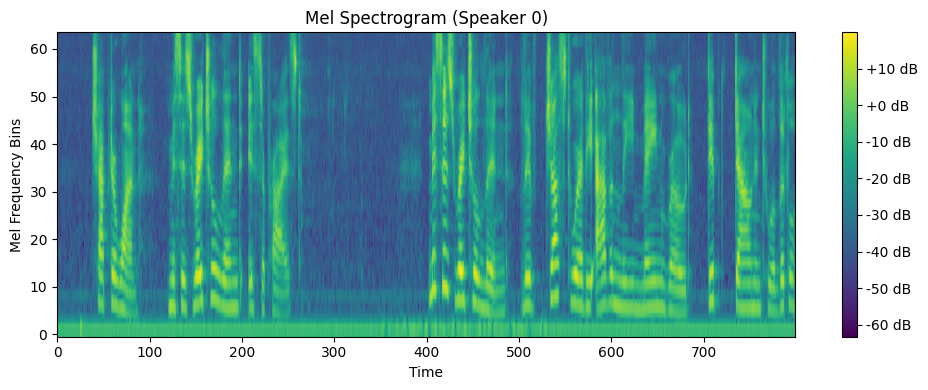

In [20]:
#import matplotlib.pyplot as plt

# Get a sample mel spectrogram from your dataset
sample_mel, sample_label = dataset[0]  # First sample
sample_mel = sample_mel.squeeze(0)     # Remove channel dim → [64, time]

# Plot it
plt.figure(figsize=(10, 4))
plt.imshow(sample_mel.numpy(), aspect='auto', origin='lower')
plt.title(f"Mel Spectrogram (Speaker {sample_label})")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bins")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

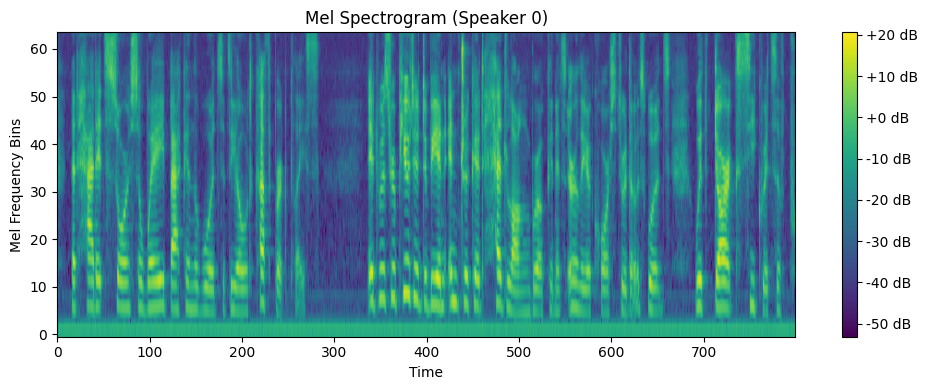

In [21]:
#import matplotlib.pyplot as plt

# Get a sample mel spectrogram from your dataset
sample_mel, sample_label = dataset[1]  # First sample
sample_mel = sample_mel.squeeze(0)     # Remove channel dim → [64, time]

# Plot it
plt.figure(figsize=(10, 4))
plt.imshow(sample_mel.numpy(), aspect='auto', origin='lower')
plt.title(f"Mel Spectrogram (Speaker {sample_label})")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bins")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [8]:
#import torch
import torch.nn as nn
#import torch.nn.functional as F

# Define a CNN model similar to the architecture shown in the image
class CNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5, padding=2)  # n1 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)              # n2 filters

        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # adjust based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
        x = x.view(-1, 64 * 7 * 7)            # Flatten
        x = F.relu(self.fc1(x))               # FC1 + ReLU
        x = self.dropout(x)
        x = self.fc2(x)                       # FC2
        return x

model = CNNModel()
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [10]:
# Optional: visualize model graph with torchviz
import torch
import torch.nn.functional as F
from torchviz import make_dot

x = torch.randn(1, 1, 28, 28)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("cnn_architecture", format="png")

'cnn_architecture.png'

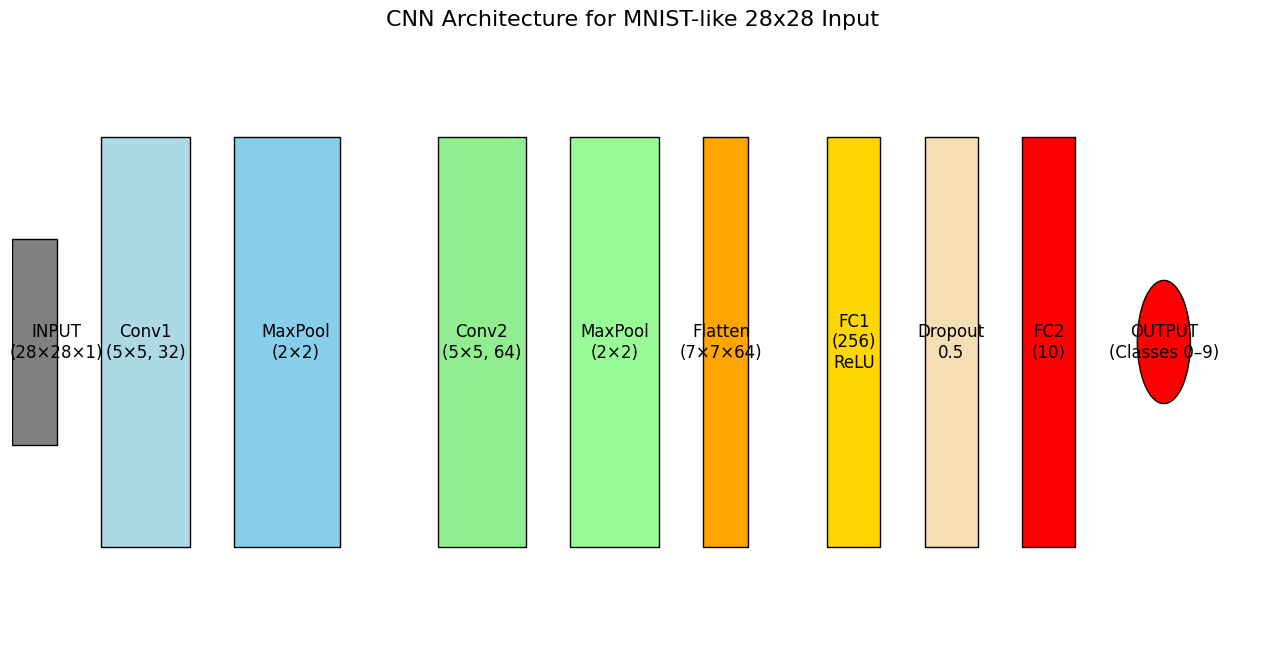

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_cnn_architecture():
    fig, ax = plt.subplots(figsize=(16, 8))

    # INPUT
    ax.text(0.5, 5.5, 'INPUT\n(28×28×1)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((0, 5), 0.5, 1, edgecolor='black', facecolor='gray'))

    # Conv1
    ax.text(1.5, 5.5, 'Conv1\n(5×5, 32)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((1, 4.5), 1, 2, edgecolor='black', facecolor='lightblue'))

    # MaxPool1
    ax.text(3.2, 5.5, 'MaxPool\n(2×2)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((2.5, 4.5), 1.2, 2, edgecolor='black', facecolor='skyblue'))

    # Conv2
    ax.text(5.3, 5.5, 'Conv2\n(5×5, 64)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((4.8, 4.5), 1, 2, edgecolor='black', facecolor='lightgreen'))

    # MaxPool2
    ax.text(6.8, 5.5, 'MaxPool\n(2×2)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((6.3, 4.5), 1, 2, edgecolor='black', facecolor='palegreen'))

    # Flatten
    ax.text(8.0, 5.5, 'Flatten\n(7×7×64)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((7.8, 4.5), 0.5, 2, edgecolor='black', facecolor='orange'))

    # FC1
    ax.text(9.5, 5.5, 'FC1\n(256)\nReLU', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((9.2, 4.5), 0.6, 2, edgecolor='black', facecolor='gold'))

    # Dropout
    ax.text(10.6, 5.5, 'Dropout\n0.5', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((10.3, 4.5), 0.6, 2, edgecolor='black', facecolor='wheat'))

    # FC2
    ax.text(11.7, 5.5, 'FC2\n(10)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((11.4, 4.5), 0.6, 2, edgecolor='black', facecolor='red'))

    # OUTPUT
    ax.text(13.0, 5.5, 'OUTPUT\n(Classes 0–9)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Circle((13, 5.5), 0.3, edgecolor='black', facecolor='red'))

    ax.set_xlim(0, 14)
    ax.set_ylim(4, 7)
    ax.axis('off')
    plt.title("CNN Architecture for MNIST-like 28x28 Input", fontsize=16)
    plt.show()

draw_cnn_architecture()
